7. Побудувати CNN на основі Xception для класифікації зображень на основі
датасету fashion-mnist.
Зробити налаштування моделі для досягнення необхідної точності. На базі
Siamese networks побудувати систему для пошуку подібних зображень в
датасеті fashion-mnist. Візуалізувати отримані результати t-SNE.

*   Методичка - https://drive.google.com/drive/u/2/folders/1JiVuXf_dHKRLb0SR045Kw9GeeVco2xNf
*   Теорія - https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d

# Завантаження, аналіз та препроцесінг даних

В основі класифікації (для пошуку подібних ) зображень пропонується використовувати Siamese
networks. Ідея складається в тому щоб взяти випадково ініціалізовану мережу і застосувати її до
зображень, щоб дізнатися наскільки вони схожі. Модель має значно полегшати виконання таких
задач, як візуальний пошук по базі даних зображень, так як вона буде мати просту метрику
подібності між 0 та 1 замість 2D масивів.

In [ ]:
# IMPORTS

import os

import pandas as pd

import numpy as np
import random

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

tf.config.run_functions_eagerly(True) # тепер всі функції запускаються повністю а не береться збережений результат

In [ ]:
# GET DATA

fashion_mnist = tf.keras.datasets.fashion_mnist

'''
This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories,
 along with a test set of 10,000 images.
This dataset can be used as a drop-in replacement for MNIST.

https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data


x_train: uint8 NumPy array of grayscale image data with shapes (60000, 28, 28), containing the training data.

y_train: uint8 NumPy array of labels (integers in range 0-9) with shape (60000,) for the training data.

x_test: uint8 NumPy array of grayscale image data with shapes (10000, 28, 28), containing the test data.

y_test: uint8 NumPy array of labels (integers in range 0-9) with shape (10000,) for the test data.
'''

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
# SHAPES

print("train_images: " + str(train_images.shape))
print("train_labels: " + str(train_labels.shape))

print("\ntest_images: " + str(test_images.shape))
print("test_labels: " + str(test_labels.shape))

train_images: (60000, 28, 28)
train_labels: (60000,)

test_images: (10000, 28, 28)
test_labels: (10000,)


Label: 9
Shape: (28, 28)
Image:


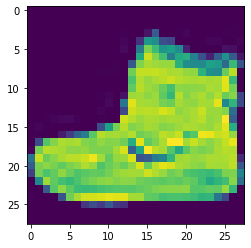

In [ ]:
# IMAGE EXAMPLE

print("Label: " + str(train_labels[0]))
print("Shape: " + str(train_images[0].shape))

print("Image:")
plt.imshow(train_images[0])
plt.show()

In [ ]:
# NORM Intensive
# для того, щоб дані мали однаковий вплив на результат (хоча в цьому випадку інших даних крім інтенсивності немає) та для правильної візуалізації

print("Before norm: " + str(train_images[0][23]))

train_images = train_images / 255.0
test_images = test_images / 255.0

print("After norm: " + str(train_images[0][23]))

Before norm: [  0   0  74 189 212 191 175 172 175 181 185 188 189 188 193 198 204 209
 210 210 211 188 188 194 192 216 170   0]
After norm: [0.         0.         0.29019608 0.74117647 0.83137255 0.74901961
 0.68627451 0.6745098  0.68627451 0.70980392 0.7254902  0.7372549
 0.74117647 0.7372549  0.75686275 0.77647059 0.8        0.81960784
 0.82352941 0.82352941 0.82745098 0.7372549  0.7372549  0.76078431
 0.75294118 0.84705882 0.66666667 0.        ]


In [ ]:
# CHECK GROUPS

'''
Знаєм що у нас є 10 груп, перевіримо це
'''

print("Unique labels: " + str(np.unique(test_labels)))
print("Unique labels count: " + str(len(np.unique(test_labels))))

Unique labels: [0 1 2 3 4 5 6 7 8 9]
Unique labels count: 10


# GLOBAL VARS

In [ ]:
# GLOBAL VARS

CLASSES = len(np.unique(test_labels))    # 10 груп
EPOCH = 17        # 17
BS = 128          # 128 - це робиться для швидшого і поступового спадання функції помилки

img_shape =  np.concatenate((test_images[1].shape, [1]))  # розмір зображення 28*28 і для кожного пікселя у нас один канал

In [ ]:
print("img_shape: " + str(img_shape))

img_shape: [28 28  1]


#Preprocessing - create pairs dataset


Ідея полягає в тому, щоб зробити батчі для навчання мережі для прискорення процесу навчання з
мінімізацією втрат по якості. Для цього потрібно створити паралельні входи для зображень A і B, де
виходом є відстань. Припускаємо, що якщо зображення знаходяться в одній групі, то їх схожість
дорівнює 1, в іншому випадку - 0.
Якщо випадковим чином вибрати усі зображення, то, швидше за все, отримаємо більшість
зображень в різних групах.

In [ ]:
# CREATE PAIRS 

def create_pairs(x, digit_indices):
    '''
      Positive and negative pair creation.
      Alternates between positive and negative pairs.

      x - масив з зображеннями
      digit_indices - матриця, рядки якої відповідають за 10 груп,
            стовпці це індекси елементів початкового масиву які належать цій групі
    '''

    pairs = []
    labels = []
    n = []

    for d in range(CLASSES):
      n.append(len(digit_indices[d])) 
    n = min(n) - 1     # шукаємо список з найменшою кількістю елементів


    for d in range(CLASSES):    # для кожного класу
        for i in range(n):      # для кожного елемента цього класу який ми обрали 

            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]  # FROM ONE GROUP
            pairs += [[x[z1], x[z2]]]         # беремо два елементи які ми прописали в digit_indices для цього класу, щоб мати пару однакових

            dn = (d + random.randrange(1, CLASSES)) % CLASSES    # обираємо інший клас рандомним чином до пари

            z1, z2 = digit_indices[d][i], digit_indices[dn][i]     # FROM DIFFERENT GROUPS
            pairs += [[x[z1], x[z2]]]   # беремо один елемент з групи і інший з іншої групи з тим самим індексом (для цього і вирівнювали) маємо різні

            labels += [1, 0]      # перше у нас з'єднання однакових груп, друге різних
    
    return np.array(pairs), np.array(labels)

In [ ]:
#TEST PAIRS CREATION
# перевіримо чи коректно працює функція побудови пар

testPairs = [[] for i in range(CLASSES)]

testPairs[0] = [0, 1] # INDEXIS IN List
testPairs[1] = [0, 1]
testPairs[2] = [0, 1]
testPairs[3] = [0, 1]
testPairs[4] = [0, 1]
testPairs[5] = [0, 1]
testPairs[6] = [0, 1]
testPairs[7] = [0, 1]
testPairs[8] = [0, 1]
testPairs[9] = [0, 1]

pairTupleImage, pairTupleLabel = create_pairs(test_images, testPairs)

print("pairTupleImage shape: " + str(pairTupleImage.shape))
print("pairTupleLabel shape: " + str(pairTupleLabel.shape))

pairTupleImage shape: (20, 2, 28, 28)
pairTupleLabel shape: (20,)


In [ ]:
# MAKE PAIR DATASET

def make_pair_dataset(images, labels):
    
    # обираємо всі елементи по групах
    digit_indices = [np.where(labels == i)[0] for i in range(CLASSES)]

    pairs, y = create_pairs(images, digit_indices)

    return pairs, y

In [ ]:
# CHECK SHAPES

pairTupleImage, pairTupleLabel = make_pair_dataset(test_images, test_labels)

print("pairTupleImage shape: " + str(pairTupleImage.shape))
print("pairTupleLabel shape: " + str(pairTupleLabel.shape))

pairTupleImage shape: (19980, 2, 28, 28)
pairTupleLabel shape: (19980,)


In [ ]:
# CHECK SHAPES

tr_pairs, tr_y = make_pair_dataset(train_images, train_labels)

print("Train pairs shape: " + str(tr_pairs.shape))
print("Train label shape: " + str(tr_y.shape))


te_pairs, te_y = make_pair_dataset(test_images, test_labels)

print("\nTest pairs shape: " + str(te_pairs.shape))
print("Test label shape: " + str(te_y.shape))

Train pairs shape: (119980, 2, 28, 28)
Train label shape: (119980,)

Test pairs shape: (19980, 2, 28, 28)
Test label shape: (19980,)


In [ ]:
# CHANGE TYPE FOR FUTURE CORRECT PREDICTION
# далі у - буде імовірністю не цілосисельною тому варто перевести в float
# float32 - 32 біти

tr_y = tr_y.astype(np.float32)
te_y = te_y.astype(np.float32)

In [ ]:
# SPLIT

# розбиваємо дані на трейн і валідацію, оскільки тест уже є
# 0.2 піде на валідацію, решта тест

# stratify - stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify

x_tra, x_val, y_tra, y_val = train_test_split(tr_pairs, tr_y, test_size=0.2, stratify=tr_y, random_state=21)

In [ ]:
# CHECK SHAPES

print('Training: ', x_tra.shape, x_tra.max())
print('Testing: ', te_pairs.shape, te_pairs.max())
print('Validation: ', x_val.shape, x_val.max())

Training:  (95984, 2, 28, 28) 1.0
Testing:  (19980, 2, 28, 28) 1.0
Validation:  (23996, 2, 28, 28) 1.0


In [ ]:
# CHECK DIVISION

# перевіряємо який поділ на однакові і не однакові пари

train_groups = [x_tra[np.where(y_tra==i)[0]] for i in np.unique(y_tra)]
test_groups = [te_pairs[np.where(te_y==i)[0]] for i in np.unique(te_y)]
val_groups = [x_val[np.where(y_val==i)[0]] for i in np.unique(y_val)]

print('Train true/false: ', [x.shape[0] for x in train_groups])
print('Test true/false: ', [x.shape[0] for x in test_groups])
print('Validation true/false: ', [x.shape[0] for x in val_groups])

Train true/false:  [47992, 47992]
Test true/false:  [9990, 9990]
Validation true/false:  [11998, 11998]


# Валідація даних

Не етапі валідації переконуємось, що генератор робить щось “розумне і правильне”. Для цього
виводяться зображення і відсоток їх подібності.

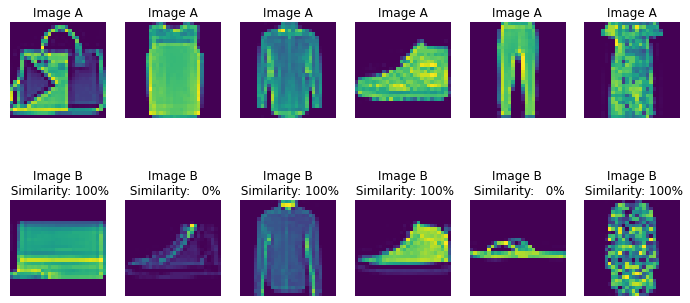

In [ ]:
# CHECK CREATED PAIRS

# візьмемо 6 прикладів пар та те чи вони однакові та візуалізуємо це

testDataX = x_tra[:6]
testDataY = y_tra[:6]


fig, m_axs = plt.subplots(2, testDataX.shape[0], figsize = (12, 6))

for pair, label, (ax1, ax2) in zip(testDataX, testDataY, m_axs.T):
  
  ax1.imshow(pair[0])
  ax1.set_title('Image A')
  ax1.axis('off')
  
  ax2.imshow(pair[1])
  ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*label))
  ax2.axis('off')

# Генерація фічей (ознак) - Xception - feature model

Для генерації фічей з зображень будуємо конволюційну мережу. Мережа ініціалізується випадковим
чином і буде навчатись генерувати корисні вектори фічей з вхідних зображень.

***Xception (2016)***

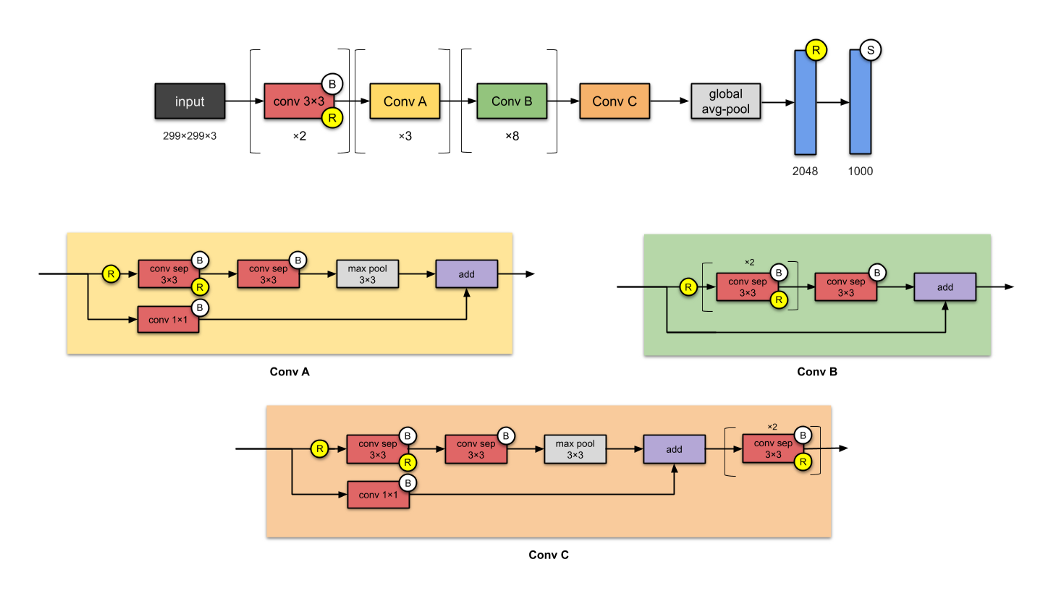

https://github.com/keras-team/keras-applications/blob/master/keras_applications/xception.py

Xception — це адаптація Inception, де модулі Inception були замінені на глибинно роздільні згортки. Він також має приблизно таку ж кількість параметрів, як і Inception-v1 ( 23M ).

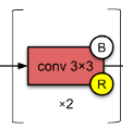

In [ ]:
def block1(x, s = 2 , filters = (64, 128)):
  f1,f2 = filters

  '''
    Conv2D - шар згортки

       f1 - input size
       name - name 
       use_bias false -  не використовується баяс
       (3,3) - розміри згортки
       (s,s) - An integer or tuple/list of 2 integers, specifying the strides of the convolution along
                 the height and width. Can be a single integer to specify the same value for all spatial dimensions.
                 Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
  '''
  '''
    Batch normalization - Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation
      close to 1.
      Importantly, batch normalization works differently during training and during inference.
      
      The layer normalizes its output using the mean and standard deviation of the current batch of inputs. That is to say, for each channel being normalized,
       the layer returns gamma * (batch - mean(batch)) / sqrt(var(batch) + epsilon) + beta
  '''
  '''
    Activation - шар активації релу
  '''
  
  x = tf.keras.layers.Conv2D(f1, (3, 3), strides=(s, s), use_bias=False, name='block1_conv1')(x)
  x = tf.keras.layers.BatchNormalization(name='block1_conv1_bn')(x)
  x = tf.keras.layers.Activation('relu', name='block1_conv1_act')(x)

  x = tf.keras.layers.Conv2D(f2, (3, 3), use_bias=False, name='block1_conv2')(x)
  x = tf.keras.layers.BatchNormalization(name='block1_conv2_bn')(x)
  x = tf.keras.layers.Activation('relu', name='block1_conv2_act')(x)

  return x

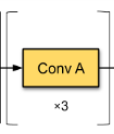

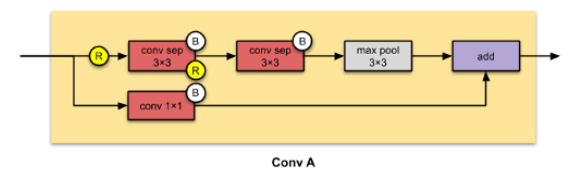

In [ ]:
def blockA(x, s = 2):


  '''
   Conv2D - 
     padding - same -  results in padding with zeros evenly to the left/right or up/down of the inpu

  '''
  
  residual = tf.keras.layers.Conv2D(128, (1, 1), strides=(s, s), padding='same', use_bias=False)(x)
  residual = tf.keras.layers.BatchNormalization()(residual)


  x = tf.keras.layers.SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv1')(x)
  x = tf.keras.layers.BatchNormalization(name='block2_sepconv1_bn')(x)

  x = tf.keras.layers.Activation('relu', name='block2_sepconv2_act')(x)
  x = tf.keras.layers.SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv2')(x)
  x = tf.keras.layers.BatchNormalization(name='block2_sepconv2_bn')(x)

  x = tf.keras.layers.MaxPooling2D((3, 3), strides=(s, s), padding='same', name='block2_pool')(x)

  x = tf.keras.layers.add([x, residual])


  residual = tf.keras.layers.Conv2D(256, (1, 1), strides=(s, s), padding='same', use_bias=False)(x)
  residual = tf.keras.layers.BatchNormalization()(residual)


  x = tf.keras.layers.Activation('relu', name='block3_sepconv1_act')(x)
  x = tf.keras.layers.SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv1')(x)
  x = tf.keras.layers.BatchNormalization(name='block3_sepconv1_bn')(x)

  x = tf.keras.layers.Activation('relu', name='block3_sepconv2_act')(x)
  x = tf.keras.layers.SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv2')(x)
  x = tf.keras.layers.BatchNormalization(name='block3_sepconv2_bn')(x)

  x = tf.keras.layers.MaxPooling2D((3, 3), strides=(s, s), padding='same', name='block3_pool')(x)

  x = tf.keras.layers.add([x, residual])


  residual = tf.keras.layers.Conv2D(728, (1, 1),  strides=(s, s),  padding='same',  use_bias=False)(x)
  residual = tf.keras.layers.BatchNormalization()(residual)


  x = tf.keras.layers.Activation('relu', name='block4_sepconv1_act')(x)
  x = tf.keras.layers.SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv1')(x)
  x = tf.keras.layers.BatchNormalization(name='block4_sepconv1_bn')(x)

  x = tf.keras.layers.Activation('relu', name='block4_sepconv2_act')(x)
  x = tf.keras.layers.SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv2')(x)
  x = tf.keras.layers.BatchNormalization(name='block4_sepconv2_bn')(x)

  x = tf.keras.layers.MaxPooling2D((3, 3), strides=(s, s), padding='same', name='block4_pool')(x)

  x = tf.keras.layers.add([x, residual])

  return x

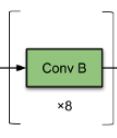

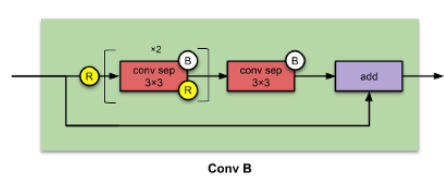

In [ ]:
def blockB (x):
      for i in range(8):
        residual = x

        prefix = 'block' + str(i + 5)

        x = tf.keras.layers.Activation('relu', name=prefix + '_sepconv1_act')(x)
        x = tf.keras.layers.SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv1')(x)
        x = tf.keras.layers.BatchNormalization(name=prefix + '_sepconv1_bn')(x)

        x = tf.keras.layers.Activation('relu', name=prefix + '_sepconv2_act')(x)
        x = tf.keras.layers.SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv2')(x)
        x = tf.keras.layers.BatchNormalization(name=prefix + '_sepconv2_bn')(x)

        x = tf.keras.layers.Activation('relu', name=prefix + '_sepconv3_act')(x)
        x = tf.keras.layers.SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv3')(x)
        x = tf.keras.layers.BatchNormalization(name=prefix + '_sepconv3_bn')(x)

        x = tf.keras.layers.add([x, residual])

      return x

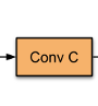

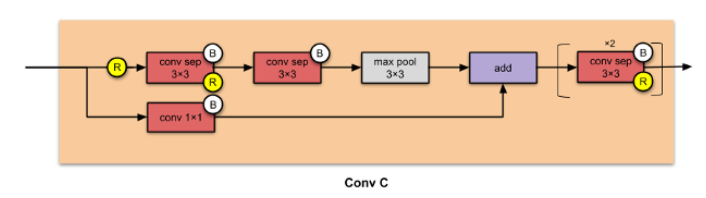

In [ ]:
def blockC(x, c = 2):
    residual = tf.keras.layers.Conv2D(1024, (1, 1), strides=(c, c), padding='same', use_bias=False)(x)
    residual = tf.keras.layers.BatchNormalization()(residual)


    x = tf.keras.layers.Activation('relu', name='block13_sepconv1_act')(x)
    x = tf.keras.layers.SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block13_sepconv1')(x)
    x = tf.keras.layers.BatchNormalization(name='block13_sepconv1_bn')(x)

    x = tf.keras.layers.Activation('relu', name='block13_sepconv2_act')(x)
    x = tf.keras.layers.SeparableConv2D(1024, (3, 3), padding='same', use_bias=False, name='block13_sepconv2')(x)
    x = tf.keras.layers.BatchNormalization(name='block13_sepconv2_bn')(x)

    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(c, c), padding='same', name='block13_pool')(x)

    x = tf.keras.layers.add([x, residual])



    x = tf.keras.layers.SeparableConv2D(1536, (3, 3), padding='same', use_bias=False, name='block14_sepconv1')(x)
    x = tf.keras.layers.BatchNormalization(name='block14_sepconv1_bn')(x)
    x = tf.keras.layers.Activation('relu', name='block14_sepconv1_act')(x)

    x = tf.keras.layers.SeparableConv2D(2048, (3, 3), padding='same', use_bias=False, name='block14_sepconv2')(x)
    x = tf.keras.layers.BatchNormalization(name='block14_sepconv2_bn')(x)
    x = tf.keras.layers.Activation('relu', name='block14_sepconv2_act')(x)
    return x

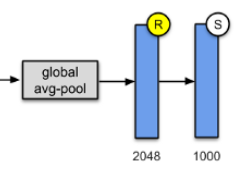

In [ ]:
def blockEnd(x, include_top = True, pooling = 'avg', classes=1000):
  
  if include_top:
        x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)

        # повнозвязний шар з софтмакс
        '''
          GlobalAveragePooling2D

        '''
        x = tf.keras.layers.Dense(classes, activation='softmax', name='predictions')(x)

  else:
        if pooling == 'avg':
            x = tf.keras.layers.GlobalAveragePooling2D()(x)

        elif pooling == 'max':
            x = tf.keras.layers.GlobalMaxPooling2D()(x)
  return x

In [ ]:
def Xception():
  # будуємо мережу з цих блоків

  input_im = tf.keras.layers.Input(shape=img_shape)

  '''
    Шар нульового заповнення для 2D введення (наприклад, зображення).

    Цей шар може додавати рядки і стовпці нулів у верхній, нижній, лівій і правій частині тензора зображення.
  '''

  x = tf.keras.layers.ZeroPadding2D(padding=(3, 3))(input_im)

  x = block1(x)
  x = blockA(x)
  x = blockB(x)
  x = blockC(x)
  x = blockEnd(x, include_top = False)

  model = tf.keras.models.Model(input_im, x, name='xception')

  return model

In [ ]:
# CREATE FEATURE MODEL

feature_model = Xception()

In [ ]:

# переглянемо, яка мережа у нас вийшла

feature_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 34, 34, 1)   0           ['input_1[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 16, 16, 64)   576         ['zero_padding2d[0][0]']         
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 16, 16, 64)  256         ['block1_conv1[0][0]']           
 ation)                                                                                    

# Siamese модель

Застосовуємо модель, яка генерує фічі, до обох зображень, а потім об'єднуємо їх разом, щоб
спрогнозувати їх подібність. Ідея моделі є такою:

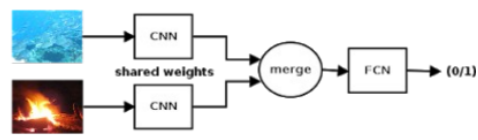

Кінцева ідея полягає в тому, що при отриманні нового зображення можна розрахувати для нього
функціональний вектор за допомогою FeatureGenerationModel. Всі існуючі зображення були
попередньо розраховані і збережені в базі даних векторів-фіч. Модель може бути застосована з
використанням декількох векторних додавань і множень для визначення найбільш схожих растрів. Ці
операції можуть бути реалізовані у вигляді збереженої процедури або всередині самої бази даних.

In [ ]:
def SiameseModel():
  # будуємо мережу для перевірки подібності

  img_a_in = tf.keras.layers.Input(shape = img_shape, name = 'ImageA_Input')
  img_b_in = tf.keras.layers.Input(shape = img_shape, name = 'ImageB_Input')

  img_a_feat = feature_model(img_a_in)
  img_b_feat = feature_model(img_b_in)

  combined_features = tf.keras.layers.concatenate([img_a_feat, img_b_feat], name='merge_features')


  combined_features = tf.keras.layers.Dense(16, activation = 'linear')(combined_features)
  combined_features = tf.keras.layers.BatchNormalization()(combined_features)
  combined_features = tf.keras.layers.Activation('relu')(combined_features)

  combined_features = tf.keras.layers.Dense(4, activation = 'linear')(combined_features)
  combined_features = tf.keras.layers.BatchNormalization()(combined_features)
  combined_features = tf.keras.layers.Activation('relu')(combined_features)

  combined_features = tf.keras.layers.Dense(1, activation = 'sigmoid')(combined_features)


  model = tf.keras.Model(inputs = [img_a_in, img_b_in], outputs=[combined_features], name = 'Similarity_Model')

  return model

In [ ]:
# CREATE SIMILARITY MODEL

similarity_model = SiameseModel()

In [ ]:

# перевіримо архітектуру моделі

similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 xception (Functional)          (None, 2048)         20933832    ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 4096)         0           ['xception[0][0]',

# Training

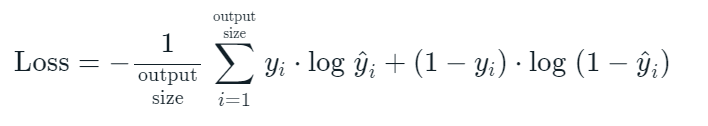

Mean absolute error

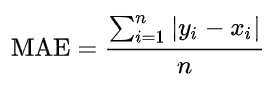

In [ ]:
# DEF PARAMS 

'''
learning_rate - для швидкості навчання
Adam - враховуються попередні градієнти і попередні моменти градієнтів, швидкість їх росту. Щоб росло спочатку швидше і не стрибало сильно
'''

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)    #1e-3
lossF = 'binary_crossentropy'
metrics = ['mae']

In [ ]:
# SET OPTIMIZER LOSS METRICS
# оголошуємо всі параметри

similarity_model.compile(optimizer = optimizer, loss = lossF, metrics = metrics)

In [ ]:
# DEF CALLBACKS
# 3 колбеки для зручної та ефективної роботи

'''
  Якщо лосс на валідації не зменшується 3  рази підряд то навчання стопається
'''

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    restore_best_weights=True
)

'''
Зберігання тренування моделі по колбекам
'''

save_model = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/Classroom/similarity_model",
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
)

'''
Поступове зменшення лернінг рейту помилка валідації не зменшується 1 крок
'''

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)

In [ ]:
# CHECK SHAPES

print("All x data shape: " + str(x_tra.shape)) 

print("\nFirst input x data shape: " + str(x_tra[:,0].shape)) 
print("\nSecond input x data shape: " + str(x_tra[:, 1].shape)) 

print("\nNew all x data shape: " + str(np.shape([x_tra[:,0], x_tra[:, 1]])))

All x data shape: (95984, 2, 28, 28)

First input x data shape: (95984, 28, 28)

Second input x data shape: (95984, 28, 28)

New all x data shape: (2, 95984, 28, 28)


In [ ]:
# REWORK DATA REPRESENTATION

xdataTrain = [x_tra[:,0], x_tra[:, 1]]
xdataVal = [x_val[:,0], x_val[:, 1]]

callbacks = [early_stopping, save_model, reduce_lr]

In [ ]:
'''xdataTrain = [x_tra[::50,0], x_tra[::50, 1]]
xdataVal = [x_val[::10,0], x_val[::10, 1]]

y_tra = y_tra[::50]
y_val = y_val[::10]'''

'xdataTrain = [x_tra[::50,0], x_tra[::50, 1]]\nxdataVal = [x_val[::10,0], x_val[::10, 1]]\n\ny_tra = y_tra[::50]\ny_val = y_val[::10]'

In [ ]:
# TRAIN MODEL
# тренуємо модельна тренувальних і валідаційних даних.

history = similarity_model.fit(
    xdataTrain,
    y_tra,
    epochs = EPOCH,
    batch_size = BS,
    validation_data = (xdataVal, y_val),
    callbacks = callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/17
750/750 [==============================] - ETA: 0s - loss: 0.3243 - mae: 0.2255

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/similarity_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/similarity_model/assets


750/750 [==============================] - 404s 526ms/step - loss: 0.3243 - mae: 0.2255 - val_loss: 0.2445 - val_mae: 0.1379 - lr: 0.0010
Epoch 2/17
750/750 [==============================] - ETA: 0s - loss: 0.2001 - mae: 0.1267

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/similarity_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/similarity_model/assets


750/750 [==============================] - 401s 535ms/step - loss: 0.2001 - mae: 0.1267 - val_loss: 0.1794 - val_mae: 0.1063 - lr: 0.0010
Epoch 3/17
750/750 [==============================] - 399s 532ms/step - loss: 0.1671 - mae: 0.1019 - val_loss: 0.1849 - val_mae: 0.1027 - lr: 0.0010
Epoch 4/17
750/750 [==============================] - ETA: 0s - loss: 0.1190 - mae: 0.0741

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/similarity_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/similarity_model/assets


750/750 [==============================] - 578s 771ms/step - loss: 0.1190 - mae: 0.0741 - val_loss: 0.1218 - val_mae: 0.0737 - lr: 2.0000e-04
Epoch 5/17
750/750 [==============================] - ETA: 0s - loss: 0.0973 - mae: 0.0601

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/similarity_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/similarity_model/assets


750/750 [==============================] - 498s 664ms/step - loss: 0.0973 - mae: 0.0601 - val_loss: 0.1131 - val_mae: 0.0643 - lr: 2.0000e-04
Epoch 6/17
750/750 [==============================] - ETA: 0s - loss: 0.0814 - mae: 0.0492

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/similarity_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/similarity_model/assets


750/750 [==============================] - 470s 627ms/step - loss: 0.0814 - mae: 0.0492 - val_loss: 0.1074 - val_mae: 0.0597 - lr: 2.0000e-04
Epoch 7/17
750/750 [==============================] - 363s 484ms/step - loss: 0.0684 - mae: 0.0413 - val_loss: 0.1078 - val_mae: 0.0554 - lr: 2.0000e-04
Epoch 8/17
750/750 [==============================] - ETA: 0s - loss: 0.0453 - mae: 0.0280

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/similarity_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/similarity_model/assets


750/750 [==============================] - 401s 534ms/step - loss: 0.0453 - mae: 0.0280 - val_loss: 0.0945 - val_mae: 0.0443 - lr: 1.0000e-04
Epoch 9/17
750/750 [==============================] - 360s 480ms/step - loss: 0.0347 - mae: 0.0215 - val_loss: 0.1023 - val_mae: 0.0443 - lr: 1.0000e-04
Epoch 10/17
750/750 [==============================] - 349s 466ms/step - loss: 0.0279 - mae: 0.0170 - val_loss: 0.1023 - val_mae: 0.0399 - lr: 1.0000e-04
Epoch 11/17
750/750 [==============================] - 348s 464ms/step - loss: 0.0227 - mae: 0.0137 - val_loss: 0.0988 - val_mae: 0.0384 - lr: 1.0000e-04


# Візуалізація результатів

Взявши невелику вибірку випадково вибраних зображень A і B першої половини з однієї і тієї ж
категорії, а другий - з різних категорій, візуалізуємо роботу моделі.
Також виведемо фактичну відстань (0 для тієї ж категорії і 1 для різних категорій), а також
прогнозовану відстань моделі.

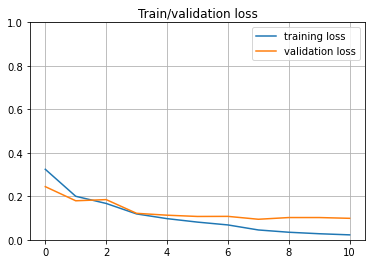

In [ ]:
# SHOW TRAIN LOSS HISTORY
# візуалізуємо графіки спадання помилки


def plot_history(history):

    plt.title('Train/validation loss')

    plt.plot(history.history['loss'], label = 'training loss')
    plt.plot(history.history['val_loss'], label = 'validation loss')

    plt.grid()
    plt.legend()
    plt.ylim(0,1)

    plt.show()

plot_history(history)

In [ ]:
# DEF SHOW PREDICT RESULTS
# зробимо кілька перевірок передбачення

def show_model_output(nb_examples = 5):
    pv_a, pv_b, pv_sim  = te_pairs[:nb_examples, 0], te_pairs[:nb_examples, 1], te_y[:nb_examples]
  
    # обрали кілька пар, тепер предіктимо чи вони однакові за мережею

    pred_sim = similarity_model.predict([pv_a, pv_b])

    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))

    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):

        ax1.imshow(c_a)
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')

        ax2.imshow(c_b)
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')

    return fig

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


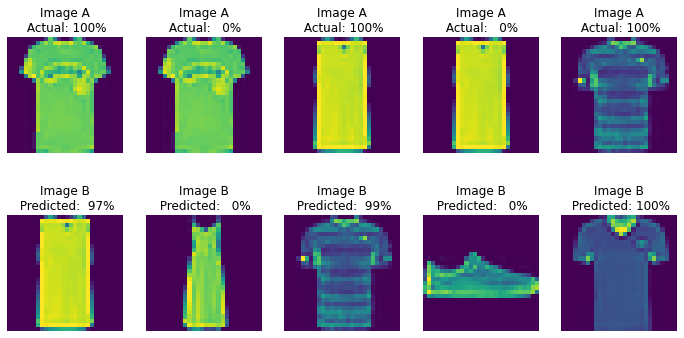

In [ ]:
_ = show_model_output()

# T-Shirt vs Ankle Boot-Plot


Беремо випадкові образи футболки і черевика (категорії 0 і 9) і обчислюємо відстань по мережі до
інших образів

In [ ]:
# TEST ON TWO EXAMPLES

# поділили зображення на групи
test_groups = [test_images[np.where(test_labels==i)[0]] for i in np.unique(train_labels)]

t_shirt_vec = np.stack([test_groups[0][0]]*test_images.shape[0], 0)    #робимо для всіх зображень це зображення як пару
t_shirt_score = similarity_model.predict([t_shirt_vec, test_images], verbose = True, batch_size = BS) # one to many check
#обчислили чи пари подібні

ankle_boot_vec = np.stack([test_groups[9][0]]*test_images.shape[0],0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, test_images], verbose = True, batch_size = BS) # one to many check

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


79/79 [==============================] - 13s 168ms/step


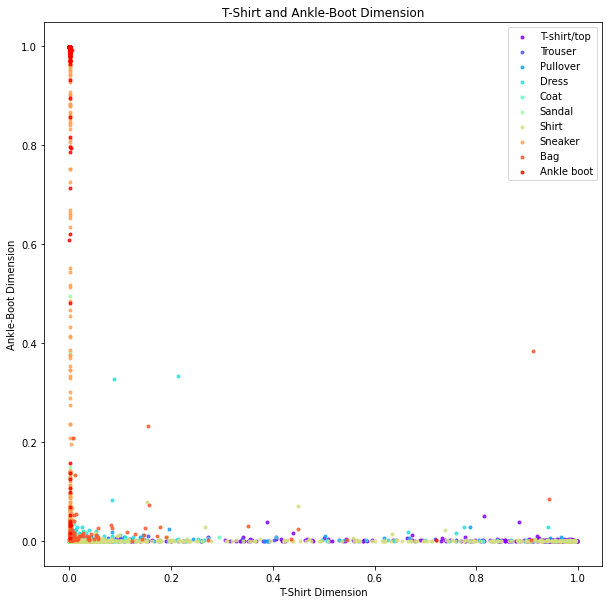

In [ ]:
# TEST
# візуалізуємо порівняння

obj_categories = ['T-shirt/top','Trouser','Pullover','Dress', 'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

# зображаємо відстані на графіку як точки
# по осі іксів t-shirt, по осі ігриків ankle-boot


for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
  plt.scatter(
      t_shirt_score[np.where(test_labels == c_group), 0],
      ankle_boot_score[np.where(test_labels == c_group), 0],
      marker='.',
      color=c_color,
      linewidth='1',
      alpha=0.8,
      label=c_label
  )

plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')

plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')

plt.savefig('tshirt-boot-dist.png')

plt.show(block=False)

# Function for similar images search

In [ ]:
# DEF FUN TO FIND SIMILAR IMAGE
# функція для пошуку різниці між зображеннями


def find_similar(image, images, count=3):
    pv_a, pv_b = np.reshape([image]*len(images), (len(images), 28,28)), np.reshape(images, (len(images), 28,28))

    # обрахувується відстань до усіх зображень

    pred_sim = similarity_model.predict([pv_a, pv_b]).ravel()

    # беруться к найближчих
    indxs = np.argsort(pred_sim)[::-1][:count]
    
    fig, m_axs = plt.subplots(2, count, figsize = (12, 6))
    i = 0

    # візуалізуєм
    for c_a, (ax1, ax2) in zip(pv_a[:count], m_axs.T):
        
        ax1.imshow(c_a)
        ax1.set_title('Input image\n')
        ax1.axis('off')

        ax2.imshow(pv_b[indxs[i]])
        ax2.set_title('Similar\n Predicted: %3.0f%%' % (100*pred_sim[indxs[i]]))
        ax2.axis('off')
        i += 1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


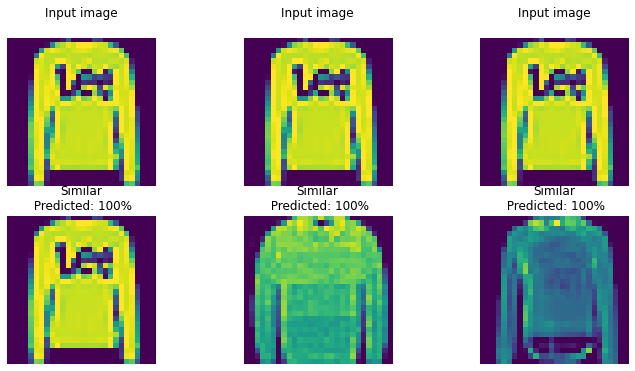

In [ ]:
# TEST FUNC
# перевіримо чи все коректно

find_similar(test_images[1], images=test_images[1:50])

# Перевірка фічей - t-SNE

Одне із найбільш важливих питань - чи за допомогою моделі Feature Generation генерувались
корисні фічі. І як можна це візуалізувати

In [ ]:
# PREDICT DATA FOR TEST

# Обраховуємо фічі для усіх тестових зображень

x_test_features = feature_model.predict(test_images, verbose = True, batch_size=BS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


79/79 [==============================] - 7s 84ms/step


In [ ]:
# BUILD TSNE

%%time
from sklearn.manifold import TSNE

'''
TSNE - є інструментом для візуалізації даних високої розмірності. Він перетворює подібність між точками 
        даних у спільні ймовірності та намагається мінімізувати розбіжність Кульбака-Лейблера між
        спільними ймовірностями низьковимірного вбудовування та високовимірними даними. t-SNE має
        функцію вартості, яка не є опуклою, тобто при різних ініціалізаціях ми можемо отримати різні
        результати.
        Ініціалізація PCA не може використовуватися з попередньо обчисленими відстанями і зазвичай є більш глобально стабільною, ніж випадкова ініціалізація.

       n_iter - ітерації оптимізації
       За замовчуванням алгоритм обчислення градієнта використовує апроксимацію Барнса-Хата, що виконується за час O(NlogN).

'''
tsne_obj = TSNE(n_components=2,
                init='pca',
                random_state=101,
                method='barnes_hut',
                n_iter=500,
                verbose=2)

tsne_features = tsne_obj.fit_transform(x_test_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.020s...
[t-SNE] Computed neighbors for 10000 samples in 9.387s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.293059
[t-SNE] Computed conditional probabilities in 0.557s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 65.3418350, gradient norm = 0.0042283 (50 iterations in 4.783s)
[t-SNE] Iteration 100: error = 65.5623016, gradient norm = 0.0018202 (50 iterations in 4.413s)
[t-SNE] Iteration 150: error = 65.5305405, gradient norm = 0.0021182 (50 iterations in 4.360s)
[t-SNE] Iteration 200: error = 65.5783844, gradient norm = 0.0016734 (50 iterations in 5.105s)
[t-SNE] Iteration 250: error = 65.8588638, gradient norm = 0.0009529 (50 iterations in 4.628s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.858864
[t-SNE] Iteration 300: error = 1.9336126, gradient norm = 0.0008935 (50 iterations in 4.683s)
[t-SNE] Iteration 350: error = 1.7221105, gradient norm = 0.0004343 (50 iterations in 4.656s)
[t-SNE] Iteration 400: error = 1.6011499, gradient norm = 0.0002946 (50 iterations in 4.523s)
[t-SNE] Iteration 450: error = 1.5072688, gradient norm = 0.0002211 (50 iterations in 4.499s)
[t-SNE] Iteration 500: error = 1.4323620, gradient norm = 0.0001730 (50 

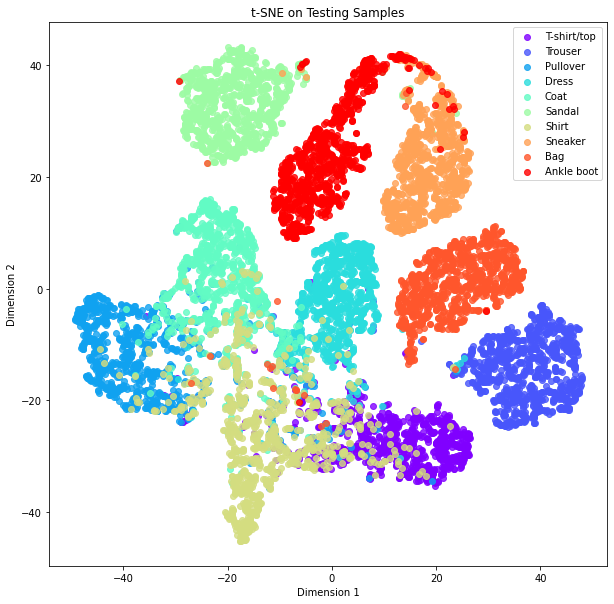

In [ ]:
# SHOW T_SNE ON TESTING SAMPLES

# усі групи які у нас є
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress', 'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

colors = plt.cm.rainbow(np.linspace(0, 1, 10))

plt.figure(figsize=(10, 10))


# формуємо точки фітч tsne для побудови графіку

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(test_labels == c_group), 0],
      tsne_features[np.where(test_labels == c_group), 1],
      marker='o',
      color=c_color,
      linewidth='1',
      alpha=0.8,
      label=c_label)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')

plt.savefig('clothes-dist.png')

plt.show(block=False)